# Exploration 14. 아이유팬이 좋아할 만한 다른 아티스트 찾기 👸

### ✔️ 실습 목표
- 추천 시스템의 개념과 목적을 이해한다.
- Implicit 라이브러리를 활용하여 Matrix Factorization(이하 MF) 기반의 추천 모델을 만들어 본다.
- 음악 감상 기록을 활용하여 비슷한 아티스트를 찾고 아티스트를 추천해 본다.
- 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 익힌다
- 유저의 행위 데이터 중 Explicit data와 Implicit data의 차이점을 익힌다.
- 새로운 데이터셋으로 직접 추천 모델을 만들어 본다.

### 💟 데이터셋 불러오기

In [81]:
# $ mkdir -p ~/aiffel/recommendata_iu/data/lastfm-dataset-360K
# $ ln -s ~/data/lastfm-dataset-360K/* ~/aiffel/recommendata_iu/data/lastfm-dataset-360K
# $ more ~/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv

# 데이터 탐색 및 전처리 
[데이터셋 홈페이지](http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html)
#### user-mboxsha1 \t musicbrainz-artist-id \t artist-name \t plays: 4개 컬럼의 의미
-  User ID, Artist MBID, Artist Name, Play횟수 


### Pandas를 활용해 데이터를 열어보기
- 데이터에는 컬럼명이 포함되어 있지 않으므로 `col_names`에 적절히 컬럼명 지정

In [84]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head(10)

,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,6531c8b1-76ea-4141-b270-eb1ac5b41375,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,21f3573f-10cf-44b3-aeaa-26cccd8448b5,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,c5db90c4-580d-4f33-b364-fbaa5a3a58b5,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,0639533a-0402-40ba-b6e0-18b067198b73,lunachicks,403


### 사용하는 컬럼만 남기고 제거하기
- `artist_MBID` 항목은 우리의 관심사가 아니다.

In [85]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


### 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔주기

In [86]:
data['artist'] = data['artist'].str.lower() # 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


### 첫 번째 유저가 어떤 아티스트의 노래를 듣는지 확인해보기

In [87]:
condition = (data['user_id']== data.loc[0, 'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


## 💟 데이터 탐색
### 추천 모델을 만들기 전에 데이터의 기본적인 정보 보기 ❣️
- 유저 수, 아티스트 수, 인기 많은 아티스트
- 유저들이 몇 명의 아티스트를 듣고 있는지에 대한 통계
- 유저 play 횟수 중앙값에 대한 통계
- (참고) `pandas.DataFrame.nunique()`은 특정 컬럼에 포함된 유니크한 데이터의 개수를 알아보는데 유용합니다.

In [88]:
# 유저 수
data['user_id'].nunique()

358868

In [89]:
# 아티스트 수
data['artist'].nunique()

291346

In [90]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(30)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
system of a down         37267
queen                    34174
u2                       33206
daft punk                33001
the cure                 32624
led zeppelin             32295
placebo                  32072
depeche mode             31916
david bowie              31862
bob dylan                31799
death cab for cutie      31482
arctic monkeys           30348
foo fighters             30144
air                      29795
the rolling stones       29754
nine inch nails          28946
sigur rós                28901
green day                28732
massive attack           28691
moby                     28232
Name: user_id, dtype: int64

In [91]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [92]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358868.000000
mean        142.187676
std         213.089902
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

## 💟 모델 검증을 위한 사용자 초기 정보 세팅
-  유튜브 뮤직 등 추천 시스템들은 이를 위해서 처음 가입하는 사용자의 취향과 유사한 아티스트 정보를 5개 이상 입력받는 과정과 비슷함
- 우리가 만든 추천 시스템의 추후 검증 과정을 위해, '나는 A를 좋아한다.'라는 정보를 위 데이터셋에 5개 이상 추가해 주어야 합니다.

### 유명한 아티스트들을 기존의 데이터에 추가해서 넣기

In [93]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


## 💟 모델에 활용하기 위한 전처리 (실습)
  우리가 다루는 데이터에서는 user와 artist 각각에 번호를 붙이고 싶습니다. 보통 이런 작업을 indexing이라고 합니다. 
 - (참고) `pandas.DataFrame.unique()`은 특정 컬럼에 포함된 유니크한 데이터만 모아 줍니다. indexing 작업을 위해 매우 유용합니다.

In [94]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [95]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['black eyed peas'])

358868
376


In [96]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,376,30
1,358868,270115,30
2,358868,3746,30
3,358868,62,30


- data의 `user_id`와 `artist 컬럼 내 값`들이 모두 정수 인덱스 값으로 잘 변경되었나요? 이것으로 훈련을 위한 전처리가 완료되었습니다!!



# CSR(Compressed Sparse Row) Matrix
CSR Matrix는 data, indices, indptr 로 행렬을 압축하여 표현합니다.
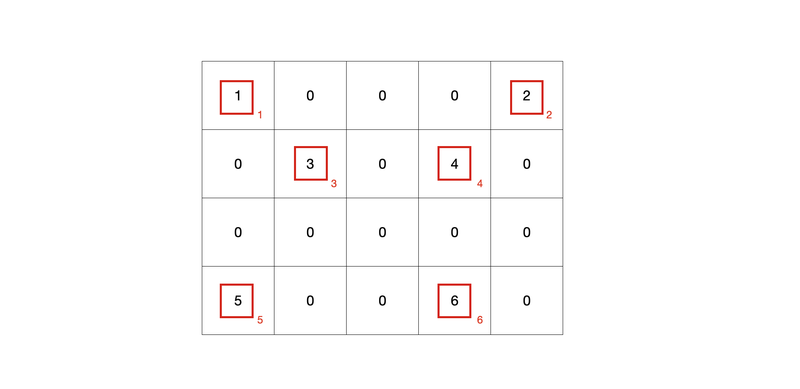
- #### data는 0이 아닌 원소를 차례로 기입한 값입니다.  
data = [1, 2, 3, 4, 5, 6]  

- #### indices는 data의 각 요소가 어느 열(column)에 있는지를 표현한 index입니다.  
indices = [0, 4, 1, 3, 0, 3]  

- #### indptr은 각 행(row)에서 0이 아닌 첫 번째 원소가 data 리스트에서 의 몇 번째에 해당하는지와 마지막에 data 벡터의 길이를 추가한 값입니다. 
이를 통해 data의 요소들이 어느 행(row)에 있는지를 알 수 있는데요. 다만 예시의 세 번째 행처럼 0이 아닌 원소가 없는 경우엔 그 다음 행의 값과 같은 값을 넣었습니다.  
indptr = [0, 2, 4, 4, 6]  

- #### 이를 통해 data[0:2]는 첫 번째 행, data[2:4]는 두 번째 행, data[4:4]는 세 번째 행, data[4:6]는 네 번째 행에 위치함을 나타낼 수 있게 됩니다.

### 💟 `scipy.sparse.csr_matrix` 사용하여 코드로 구현하기

In [97]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data

<358869x291347 sparse matrix of type '<class 'numpy.int64'>'
	with 17535578 stored elements in Compressed Sparse Row format>

## 💟 MF(Matrix Factorization) 모델 학습하기
### implicit 패키지란 ❓
- `[implicit](https://github.com/benfred/implicit)` 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
- 이 패키지에 구현된 `als(AlternatingLeastSquares)` 모델을 사용하겠습니다. Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, **한쪽을 고정시키고 다른 쪽을 학습하는 방식**을 번갈아 수행하는 `AlternatingLeastSquares` 방식이 효과적인 것으로 알려져 있습니다.

In [98]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

### 💟 AlternatingLeastSquares 클래스의 __init__ 파라미터
1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
3. use_gpu : GPU를 사용할 것인지
4. iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

#### 1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 한다 ❣️

In [99]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [100]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291347x358869 sparse matrix of type '<class 'numpy.int64'>'
	with 17535578 stored elements in Compressed Sparse Column format>

In [101]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

1. Zimin 벡터와 black eyed peas의 벡터를 어떻게 만들고 있는지
2. 두 벡터를 곱하면 어떤 값이 나오는지


In [102]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

print('슝=3')

슝=3


In [103]:
zimin_vector

array([-0.11791286, -0.44059503,  0.6274041 ,  0.05201745, -0.33329222,
        1.3724815 ,  0.41528553,  0.05981413,  0.24289122, -0.8837624 ,
       -0.06763773,  0.0888429 , -0.32343358, -1.2221131 ,  0.626524  ,
        0.80730605,  0.18802324,  0.29522282,  0.5267435 ,  0.1872374 ,
       -0.689638  , -0.17075631, -1.0117873 ,  0.712744  , -0.17981651,
       -0.01114231,  0.15880962, -0.08244485, -0.29994255, -0.9266171 ,
       -1.1251281 ,  0.7781146 ,  0.9039564 ,  0.8956328 ,  0.08426811,
        0.29681325, -0.4165902 ,  1.0148681 , -0.05684601,  0.44581234,
       -0.49030092,  1.8495954 , -0.7231076 , -0.59761524, -0.44001338,
        0.14673337,  0.585308  ,  0.19834264,  1.0138823 ,  0.0095162 ,
        0.08521759,  0.31794176,  0.02650611, -0.84453195, -0.42290112,
        0.0984308 ,  0.23476921,  0.22798549,  0.4725018 ,  0.77169734,
        0.08564238, -1.0036803 , -1.8479612 ,  0.43569455,  0.3345153 ,
       -0.88215023, -0.05639586,  0.8261253 ,  0.04799945,  0.14

In [104]:
black_eyed_peas_vector

array([ 0.01194676, -0.00691506,  0.00498223,  0.0044352 ,  0.00706162,
        0.01944652, -0.00371827,  0.01014623,  0.01156635, -0.00435635,
       -0.00697781,  0.01113099, -0.01443159,  0.00274492,  0.00348965,
        0.02011871,  0.01138582, -0.00049284,  0.01010295,  0.00996878,
       -0.00161387,  0.01171317, -0.00424769,  0.00234763,  0.00436537,
       -0.00081108, -0.00417696,  0.03078197,  0.00772266, -0.01531152,
       -0.00446536,  0.02107077,  0.02079027,  0.01500431, -0.00581519,
        0.00549578,  0.01338984,  0.0258194 , -0.00663332,  0.0083082 ,
       -0.00372349,  0.03667998,  0.00225512, -0.0048627 ,  0.00992689,
        0.00820145,  0.01154133,  0.00780385,  0.00202357,  0.00319591,
        0.00713522, -0.00998917,  0.00705391, -0.01322967,  0.00602506,
       -0.00041192,  0.01620716, -0.00327467,  0.0116777 ,  0.02781337,
        0.00561348, -0.00195861, -0.01324002,  0.02106674,  0.02074455,
        0.01292555,  0.01062418,  0.02283926,  0.01203881,  0.01

In [105]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.5075084

1이 나와야 될 것 같은데 한참 낮은 수치인 0.52 정도가 나왔습니다. factors를 늘리거나 iterations를 늘려야 할 것 같습니다. 이후 진행되는 내용은 일단 이렇게 학습된 모델을 사용하겠습니다.

#### - queen에 대한 선호도를 어떻게 예측할지 한 번 확인해보기 

In [106]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.30481994

## 💟 비슷한 아티스트 찾기
`AlternatingLeastSquares` 클래스에 구현되어 있는 similar_items 메서드를 통하여 비슷한 아티스트를 찾습니다. 

#### - coldplay로 찾아보기

In [107]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 1.0000001),
 (277, 0.9904991),
 (5, 0.9826776),
 (28, 0.97923744),
 (473, 0.9762148),
 (217, 0.9734484),
 (247, 0.96394295),
 (490, 0.9631763),
 (418, 0.9610565),
 (268, 0.9509279),
 (910, 0.9508387),
 (694, 0.9461803),
 (1018, 0.945222),
 (773, 0.9417391),
 (782, 0.9382991)]

- (아티스트의 id, 유사도) Tuple 로 반환하고 있습니다. 아티스트의 id를 다시 아티스트의 이름으로 매핑 시켜 주겠습니다.

In [108]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'red hot chili peppers',
 'the killers',
 'placebo',
 'radiohead',
 'the beatles',
 'oasis',
 'u2',
 'pink floyd',
 'nirvana',
 'foo fighters',
 'the smashing pumpkins',
 'nine inch nails',
 'the white stripes']

- 몇 번 더 반복해서 확인하기 위해 위의 코드를 함수로 만들고 확인해 보겠습니다.

In [109]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

print("슝=3")

슝=3


- 힙합 2pac으로도 확인해 보기

In [110]:
get_similar_artist('2pac')

['2pac',
 'dr. dre',
 'the game',
 'nas',
 '50 cent',
 'notorious b.i.g.',
 'jay-z',
 'snoop dogg',
 'dmx',
 'busta rhymes']

> 마니아들은 특정 장르의 아티스트들에게로 선호도가 집중되고, 다른 장르의 아티스트들과는 선호도가 낮게 나타날 것입니다. 이런 마니아들의 존재로 인해 같은 장르의 아티스트들의 벡터들도 더 가까워져서 `get_similar_artist`시 장르별 특성이 두드러지게 될 것입니다.

In [111]:
get_similar_artist('lady gaga')

['lady gaga',
 'britney spears',
 'katy perry',
 'rihanna',
 'beyoncé',
 'the pussycat dolls',
 'christina aguilera',
 'mariah carey',
 'kelly clarkson',
 'leona lewis']

## 💟 유저에게 아티스트 추천하기
`AlternatingLeastSquares` 클래스에 구현되어 있는 `recommend` 메서드를 통하여 제가 좋아할 만한 아티스트를 추천받습니다. `filter_already_liked_items` 는 유저가 이미 평가한 아이템은 제외하는 Argument입니다.

In [112]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
artist_recommended

[(350, 0.45178962),
 (550, 0.4485093),
 (369, 0.43029737),
 (627, 0.42468482),
 (354, 0.42034975),
 (1800, 0.41379994),
 (391, 0.41321862),
 (355, 0.39989042),
 (724, 0.3961575),
 (274, 0.38933924),
 (2249, 0.38869274),
 (901, 0.38750678),
 (409, 0.37759137),
 (618, 0.36643052),
 (621, 0.3644923),
 (1777, 0.35672462),
 (5, 0.3546959),
 (382, 0.35424483),
 (28, 0.35206532),
 (277, 0.35194987)]

In [113]:
[idx_to_artist[i[0]] for i in artist_recommended]

['rihanna',
 'britney spears',
 'justin timberlake',
 'maroon 5',
 'nelly furtado',
 'lady gaga',
 'christina aguilera',
 'madonna',
 'lily allen',
 'michael jackson',
 'katy perry',
 'pink',
 'amy winehouse',
 'the pussycat dolls',
 'alicia keys',
 'mariah carey',
 'red hot chili peppers',
 'mika',
 'the killers',
 'muse']

#### - AlternatingLeastSquares 클래스에 구현된 `explain` 메서드를 사용하여 제가 기록을 남긴 데이터 중 이 추천에 기여한 정도를 확인
이 method는 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됩니다.)를 반환합니다

In [114]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)

In [115]:
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.21108508068307005),
 ('black eyed peas', 0.14904756226599314),
 ('jason mraz', 0.04794198233142122),
 ('coldplay', 0.04650798674116241),
 ('maroon5', -2.7672997787614348e-05)]

### 😂 아쉬운 점 😂
1. 유저, 아티스트에 대한 Meta 정보를 반영하기 쉽지 않습니다. 연령대별로 음악 취향이 굉장히 다르지 않을까요? 
2. 유저가 언제 play 했는지에 반영하기 쉽지 않습니다. 10년 전에 즐겨듣던 아티스트와 지금 즐겨듣는 아티스트를 비교해 보세요.

>이러한 이유와 딥러닝의 발전으로 MF 이외의 모델 구조도 많이 연구/ 사용되고 있습니다. 하지만 어떤 추천 모델도 핵심은 MF와 비슷합니다.
유저와 아이템에 대한 벡터를 잘 학습하여 취향에 맞게(유저에 맞게) 아이템을 `보여주거나(Retrieval) 걸러내는(Filtering)` 역할입니다.

--- 
# Movielens 영화 추천 실습 🧜‍♀️🧜‍♀️🧜‍♀️
데이터셋:  Movielens 데이터
    
- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

## Step 0. 데이터 불러오기

In [116]:
# $ mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
# $ ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m

## Step 1. 데이터 준비와 전처리
Movielens 데이터는 `rating.dat` 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

In [127]:
# 필요한 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [128]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [129]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [130]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'movie_id', 'ratings'] # timestamp 항목은 불필요하여 제거
ratings = ratings[using_cols]
ratings.head()

,user_id,movie_id,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [131]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'ratings':'count'}, inplace=True)

In [132]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [133]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['movie_id', 'title']  # genre 항목은 불필요하여 제거
movies = movies[using_cols]
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [134]:
ratings['user_id'].nunique()

6039

In [135]:
ratings['user_id'].head()

0    1
1    1
2    1
3    1
4    1
Name: user_id, dtype: int64

In [136]:
ratings['user_id'].tail()

1000203    6040
1000205    6040
1000206    6040
1000207    6040
1000208    6040
Name: user_id, dtype: int64

## Step 2. 분석해보기

In [137]:
# 분석을 위해 데이터를 병합합니다.
df = movies.set_index("movie_id") # movie_id를 인덱스로 지정합니다.
ratings = ratings.join(df, on = "movie_id") # movie_id를 기준으로 데이터를 병합합니다.

ratings.head()

,user_id,movie_id,count,title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,James and the Giant Peach (1996)
2,1,914,3,My Fair Lady (1964)
3,1,3408,4,Erin Brockovich (2000)
4,1,2355,5,"Bug's Life, A (1998)"


In [138]:
# ratings에 있는 유니크한 영화 수
movie_unique = ratings['title'].nunique()
print('ratings에 있는 유니크한 영화 개수: {}'.format(movie_unique))

ratings에 있는 유니크한 영화 개수: 3628


In [139]:
# 유저 수 확인
user_unique = ratings['user_id'].nunique()
print('ratings에 있는 유니크한 사용자 수: {}'.format(user_unique))

ratings에 있는 유니크한 사용자 수: 6039


In [140]:
# 가장 인기 있는 영화 30개
popular_movies = ratings.groupby('title')['user_id'].count().sort_values(ascending=False).head(30)
print('가장 인기 있는 영화 30개(인기순):\n {}'.format(popular_movies))

가장 인기 있는 영화 30개(인기순):
 title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                  

### Step 3. 내가 선호하는 영화 5가지 골라서 rating에 추가하기

In [141]:
# 인덱스와 영화명으로 서로 반환할 수 있는 딕셔너리를 생성합니다.
idx_to_movie = {i:v for i,v in zip(movies['movie_id'], movies['title'])}
movie_to_idx = {v:i for i,v in zip(movies['movie_id'], movies['title'])}

In [142]:
# 영화 전체 목록을 확인해봅시다. 
for key, value in idx_to_movie.items():
    print(key, value)

1 Toy Story (1995)
2 Jumanji (1995)
3 Grumpier Old Men (1995)
4 Waiting to Exhale (1995)
5 Father of the Bride Part II (1995)
6 Heat (1995)
7 Sabrina (1995)
8 Tom and Huck (1995)
9 Sudden Death (1995)
10 GoldenEye (1995)
11 American President, The (1995)
12 Dracula: Dead and Loving It (1995)
13 Balto (1995)
14 Nixon (1995)
15 Cutthroat Island (1995)
16 Casino (1995)
17 Sense and Sensibility (1995)
18 Four Rooms (1995)
19 Ace Ventura: When Nature Calls (1995)
20 Money Train (1995)
21 Get Shorty (1995)
22 Copycat (1995)
23 Assassins (1995)
24 Powder (1995)
25 Leaving Las Vegas (1995)
26 Othello (1995)
27 Now and Then (1995)
28 Persuasion (1995)
29 City of Lost Children, The (1995)
30 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
31 Dangerous Minds (1995)
32 Twelve Monkeys (1995)
33 Wings of Courage (1995)
34 Babe (1995)
35 Carrington (1995)
36 Dead Man Walking (1995)
37 Across the Sea of Time (1995)
38 It Takes Two (1995)
39 Clueless (1995)
40 Cry, the Beloved Country (1995)
41 Ri

1158 Here Comes Cookie (1935)
1159 Love in Bloom (1935)
1160 Six of a Kind (1934)
1161 Tin Drum, The (Blechtrommel, Die) (1979)
1162 Ruling Class, The (1972)
1163 Mina Tannenbaum (1994)
1164 Two or Three Things I Know About Her (1966)
1165 Bloody Child, The (1996)
1166 Farmer & Chase (1995)
1167 Dear God (1996)
1168 Bad Moon (1996)
1169 American Dream (1990)
1170 Best of the Best 3: No Turning Back (1995)
1171 Bob Roberts (1992)
1172 Cinema Paradiso (1988)
1173 Cook the Thief His Wife & Her Lover, The (1989)
1174 Grosse Fatigue (1994)
1175 Delicatessen (1991)
1176 Double Life of Veronique, The (La Double Vie de Véronique) (1991)
1177 Enchanted April (1991)
1178 Paths of Glory (1957)
1179 Grifters, The (1990)
1180 Hear My Song (1991)
1181 Shooter, The (1995)
1183 English Patient, The (1996)
1184 Mediterraneo (1991)
1185 My Left Foot (1989)
1186 Sex, Lies, and Videotape (1989)
1187 Passion Fish (1992)
1188 Strictly Ballroom (1992)
1189 Thin Blue Line, The (1988)
1190 Tie Me Up! Tie Me Do

2661 It Came from Outer Space (1953)
2662 War of the Worlds, The (1953)
2663 It Came from Beneath the Sea (1955)
2664 Invasion of the Body Snatchers (1956)
2665 Earth Vs. the Flying Saucers (1956)
2666 It Conquered the World (1956)
2667 Mole People, The (1956)
2668 Swamp Thing (1982)
2669 Pork Chop Hill (1959)
2670 Run Silent, Run Deep (1958)
2671 Notting Hill (1999)
2672 Thirteenth Floor, The (1999)
2673 Eternity and a Day (Mia eoniotita ke mia mera ) (1998)
2674 Loss of Sexual Innocence, The (1999)
2675 Twice Upon a Yesterday (1998)
2676 Instinct (1999)
2677 Buena Vista Social Club (1999)
2678 Desert Blue (1999)
2679 Finding North (1999)
2680 Floating (1997)
2681 Free Enterprise (1998)
2682 Limbo (1999)
2683 Austin Powers: The Spy Who Shagged Me (1999)
2684 Taxman (1999)
2685 Red Dwarf, The (Le Nain rouge) (1998)
2686 Red Violin, The (Le Violon rouge) (1998)
2687 Tarzan (1999)
2688 General's Daughter, The (1999)
2689 Get Bruce (1999)
2690 Ideal Husband, An (1999)
2691 Legend of 1900,

In [143]:
# 좋아하는 영화 5개를 입력합니다.
my_favorite = ['Great Escape, The (1963)', 'Men in Black (1997)',  'Batman Forever (1995)', 'Star Trek: The Motion Picture (1979)', 'Die Hard 2 (1990)']

In [144]:
# 좋아하는 영화의 인덱스번호를  별도의 리스트에 넣어줍니다.
my_idx = []
for i in my_favorite:
    my_idx.append(movie_to_idx[i])
my_idx

[1262, 1580, 153, 1371, 1370]

In [145]:
# 선호 영화 정보를 모아서 DataFrame로 만듭니다. 
my_playlist = pd.DataFrame({'user_id': ['6041']*5,'movie_id':my_idx, 'title': my_favorite, 'count':[5]*5})

# 유저 id가 포함되어 있는 지 확인하고 없으면 my_playlist 데이터를 추가합니다.
if not ratings.isin({'user_id':['6041']})['user_id'].any():
    ratings = ratings.append(my_playlist)

ratings.tail(10)

,user_id,movie_id,count,title
1000203,6040,1090,3,Platoon (1986)
1000205,6040,1094,5,"Crying Game, The (1992)"
1000206,6040,562,5,Welcome to the Dollhouse (1995)
1000207,6040,1096,4,Sophie's Choice (1982)
1000208,6040,1097,4,E.T. the Extra-Terrestrial (1982)
0,6041,1262,5,"Great Escape, The (1963)"
1,6041,1580,5,Men in Black (1997)
2,6041,153,5,Batman Forever (1995)
3,6041,1371,5,Star Trek: The Motion Picture (1979)
4,6041,1370,5,Die Hard 2 (1990)


In [146]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()
print('user_id:', num_user)
print('movie_id:', num_movie)

user_id: 6040
movie_id: 3628


## Step 4. CSR matrix를 직접 만들어보기

In [147]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [148]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_ratings = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_ratings) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_ratings   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_ratings = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_ratings) == len(ratings):
    print('movie column indexing OK!!')
    ratings['title'] = temp_movie_ratings
else:
    print('movie column indexing Fail!!')

ratings

user_id column indexing OK!!
movie column indexing OK!!


,user_id,movie_id,count,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
0,6039,1262,5,762
1,6039,1580,5,175
2,6039,153,5,515
3,6039,1371,5,581


In [149]:
csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.title)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

## Step 5. `als_model(AlternatingLeastSquares)` 모델을 직접 구성하여 훈련시키기

In [150]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [151]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [152]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [153]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

## Step 6. 훈련된 모델이 예측한 나의 선호도를 파악해보기
- 선호하는 5가지 영화 중 하나와 그 외의 영화 하나 고르기
- 일부러 비슷한 액션 장르 영화 선정

In [155]:
batman, diehard = user_to_idx['6041'], movie_to_idx['Batman Forever (1995)']
batman_vector, diehard_vector = als_model.user_factors[batman], als_model.item_factors[diehard]

np.dot(batman_vector, diehard_vector)

0.22642568

- 결과값이 0.22가 나왔습니다.
- 데이터 양이 적긴 하지만 선호하는 영화들을 일부러 비슷한 장르로 넣었는데 왜 이런 결과가 나왔는지 의아하네요 ....

## Step 7. 내가 좋아하는 영화와 비슷한 영화 추천받기

In [156]:
# 내가 좋아하는 영화와 인덱스를 다시 확인해 봅시다.
print(my_favorite)
print(my_idx)

['Great Escape, The (1963)', 'Men in Black (1997)', 'Batman Forever (1995)', 'Star Trek: The Motion Picture (1979)', 'Die Hard 2 (1990)']
[1262, 1580, 153, 1371, 1370]


In [157]:
similar_movie = als_model.similar_items(551)
similar_movie   # (movie idx, 유사도) Tuple

[(551, 1.0000002),
 (37, 0.8908406),
 (46, 0.8821915),
 (572, 0.8745329),
 (8, 0.8287258),
 (528, 0.81022316),
 (619, 0.787745),
 (536, 0.7818881),
 (547, 0.7775669),
 (17, 0.7432804)]

In [158]:
# 유사한 영화 제목을 확인해봅니다.
[idx_to_movie[i[0]] for i in similar_movie]

['Nightmare Before Christmas, The (1993)',
 'Across the Sea of Time (1995)',
 'How to Make an American Quilt (1995)',
 'Foreign Student (1994)',
 'Tom and Huck (1995)',
 'Scout, The (1994)',
 'Ed (1996)',
 'Simple Twist of Fate, A (1994)',
 'Surviving the Game (1994)',
 'Sense and Sensibility (1995)']

## Step 8. 내가 가장 좋아할 만한 영화들을 추천받기

In [160]:
user = user_to_idx['6041']

artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
artist_recommended

[(107, 0.3757046),
 (471, 0.30233714),
 (587, 0.27873117),
 (113, 0.27701455),
 (558, 0.2747135),
 (92, 0.27150115),
 (60, 0.26452148),
 (62, 0.2644508),
 (82, 0.26073247),
 (58, 0.23410076),
 (138, 0.23248954),
 (179, 0.22579059),
 (150, 0.22141762),
 (140, 0.20500852),
 (544, 0.20160103),
 (699, 0.19706272),
 (586, 0.1967208),
 (583, 0.19474335),
 (584, 0.19392717),
 (145, 0.18408898)]

In [161]:
[idx_to_movie[i[0]] for i in artist_recommended]

['Muppet Treasure Island (1996)',
 'Hudsucker Proxy, The (1994)',
 'Ghost (1990)',
 'Before and After (1996)',
 'Pagemaster, The (1994)',
 'Mary Reilly (1996)',
 'Indian in the Cupboard, The (1995)',
 "Mr. Holland's Opus (1995)",
 "Antonia's Line (Antonia) (1995)",
 'Postino, Il (The Postman) (1994)',
 'Neon Bible, The (1995)',
 'Mad Love (1995)',
 'Apollo 13 (1995)',
 'Up Close and Personal (1996)',
 'Striking Distance (1993)',
 'To Cross the Rubicon (1991)',
 'Home Alone (1990)',
 'Dear Diary (Caro Diario) (1994)',
 "I Don't Want to Talk About It (De eso no se habla) (1993)",
 'Bad Boys (1995)']

# 회고

1. 평소에 넷플릭스나 유튜브 등을 시청하면서 추천 시스템이 어떻게 작동하고 있는지 궁금했었다. 너무 비슷한 콘텐츠만 추천을 해주다보니 나의 선택의 폭이 좁아지는 듯한 느낌이 들어서 이 알고리즘을 정확하게 파악하여 더이상 컨트롤 받지 않고 싶었다. 이번 기회를 통해 자세히 배울 수 있어 좋았다.
2. CSR matrix가 무엇인지 이해하기 어려웠는데, 하다보니 감은 잡혔다. 여기서 배우는 모든 모델들을 이해하기 위해서는 수학적인 개념이 바탕이 되어야 한다는 것을 또 한번 느낄 수 있었다. 
3. MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정된 것 같다. 일부러 내가 선호하는 영화들을 선택할 때 비슷한 장르들을 선택했는데 그 것 때문인 것 같기도 하다. 
4. 다음에는 더 정확한 추천 시스템을 만들어보고 싶다. ☺️☺️